In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

# 1.Random Data Generator 

* univariate gaussian data

In [66]:
def Mean(x):
    return sum(x) / len(x)

def Variance(x):
    u = Mean(x)
    return sum([(i - u)**2 for i in x]) / len(x)

def Box_Muller():
    U, V = np.random.uniform(0, 1, 2)
    X = math.sqrt(-2 * math.log(U)) * math.cos(2*math.pi*V)
    Y = math.sqrt(-2 * math.log(V)) * math.cos(2*math.pi*U)
    
    return X

def GaussianDataGenerator(u, v):
    while True:
        D = Box_Muller()
        yield u + math.sqrt(v) * D

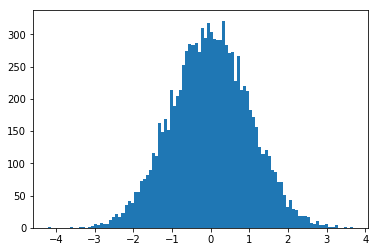

[-0.0027942374802836186, 1.023696186019565]

In [72]:
GDG = GaussianDataGenerator(0, 1)

Gdatas = [next(GDG) for _ in range(10000)]

plt.hist(Gdatas, 100)
plt.show()
[Mean(Gdatas), Variance(Gdatas)]

* polynomial basis linear model

In [73]:
def Gaussian(u, v):
    return lambda x : (math.exp(-1*(((x - u)**2) / (2*v) ) ) / math.sqrt(2*math.pi*v))

def Polynomial(w):
    return lambda x : sum([w[i]*(x**i) for i in range(len(w))])

def PolynomialDataGenerator(a, w):
    x_constraint=(-1,1)
    e = GaussianDataGenerator(u=0,v=a)
    phi = Polynomial(w)
    while True:
        x = random.uniform(x_constraint[0], x_constraint[1])
        y = phi(x) + next(e)
        yield x, y

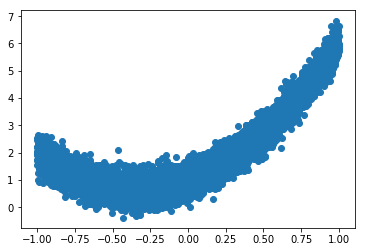

In [75]:
dg = PolynomialDataGenerator(0.1, [1, 2, 3])
tmp = [next(dg) for _ in range(10000)]
x = [item[0] for item in tmp]
y = [item[1] for item in tmp]

plt.scatter(x, y)
plt.show()

# 2. Sequential Estimator

In [76]:
def SequentialEstimator(m, s):
    print('Data point source function: N({}, {})\n\n'.format(m, s))
    
    gen  = GaussianDataGenerator(m, s)
    x    = next(gen)
    n    = 1 #總共多少data
    M_2n = 0
    var  = 0
    mean_old  = x
    MAX_itera = 10000
    epsilon   = 10 ** -3
    while n < MAX_itera:
        x = next(gen)
        n += 1
        
        mean = mean_old + (x - mean_old)/n
        M_2n = M_2n + (x - mean_old) * (x - mean)
        var = M_2n / (n-1)
        
        #Show results
        if abs(mean_old-mean) < epsilon:
            print('Add data point: {} Total data: {}\nMean = {} Variance = {}'.format(x, n, mean, var))
            break
        print('Add data point: {} Total data: {}\nMean = {} Variance = {}'.format(x, n, mean, var))
        
        mean_old = mean

In [77]:
SequentialEstimator(3, 5)

Data point source function: N(3, 5)


Add data point: 4.597047307101587 Total data: 2
Mean = 4.038860521265995 Variance = 0.6231449757629368
Add data point: 4.124933544556921 Total data: 3
Mean = 4.067551529029637 Variance = 0.3140420096609485
Add data point: 6.939860742595529 Total data: 4
Mean = 4.78562883242111 Variance = 2.271901394357845
Add data point: 9.613195788949138 Total data: 5
Mean = 5.751142223726715 Variance = 6.365006589720642
Add data point: 2.8573361914601656 Total data: 6
Mean = 5.268841218348957 Variance = 6.487690830506892
Add data point: 1.3391035533338136 Total data: 7
Mean = 4.707450123346794 Variance = 7.6125287562565065
Add data point: 2.696656669253117 Total data: 8
Mean = 4.456100941585084 Variance = 7.030435937598111
Add data point: 5.110733730212076 Total data: 9
Mean = 4.528837918099194 Variance = 6.199247455170075
Add data point: 3.5916359171521286 Total data: 10
Mean = 4.435117718004488 Variance = 5.598276941431318
Add data point: 4.870714183917443 Tota

# 3. Bayesian Linear regression

In [102]:
def Bayesian(b, a, w):
    gen = PolynomialDataGenerator(a, w)
    n = len(w)
    I = np.eye(n)
    
    S0 = b * I
    m0 = np.zeros(len(w)).reshape(-1, 1)

    X_data = []
    Y_data = []
    S1_data = []
    m1_data = []
    posterior = []
    predictive = []
    
    max_iter = 1000
    num = 0
    while num < max_iter:
        num += 1
        x, y = next(gen)
        X = np.array([[x**i for i in range(n)]])

        
        S1 = (1/a) * X.T.dot(X) + S0
        m1 = np.linalg.inv(S1).dot((1/a) * y * X.T  + S0.dot(m0))
        
        ym = X.dot(m1)[0, 0]
        yv = (a + X.dot(np.linalg.inv(S1)).dot(X.T))[0, 0]
        
        X_data.append(x)
        Y_data.append(y)
        if num == 10 or num == 50 or num == max_iter:
            S1_data.append(S1)
            m1_data.append(m1)
        
        if num <= 5 or num > 995:
            posterior.append((m1, S1))
            predictive.append((ym, yv))

        m0 = m1
        S0 = S1
        
        
    return S1_data, m1_data, X_data, Y_data, posterior, predictive
        

    



In [124]:
def show(b, a, w):
    data = Bayesian(b, a, w)
    
    S1_data, m1_data, X_data, Y_data, posterior, predictive = data
    n = len(w)
    I = np.eye(n)
    
    X = np.linspace(-2, 2, num=100)
    Y = [] #ground truth
    M = [] #ground truth, 10, 50, all
    U = [] #ground truth, 10, 50, all
    L = [] #ground truth, 10, 50, all
    
    for incomes in range(4):
        for x in X: 
            d = np.array([[x**i for i in range(n)]])
            
            if incomes == 0:
                v = (a + d.dot(np.linalg.inv(S1_data[-1])).dot(d.T))[0, 0]
                m = 0
                y = sum([w[i] * x**i for i in range(n)])
                M.append(m)
                Y.append(y)
                U.append(y+2*math.sqrt(v))
                L.append(y-2*math.sqrt(v))
            else:
                v = (a + d.dot(np.linalg.inv(S1_data[incomes-1])).dot(d.T))[0, 0]
                m = (d.dot(m1_data[incomes-1]))[0, 0]
                M.append(m)
                U.append(m+2*math.sqrt(v))
                L.append(m-2*math.sqrt(v))

    for i, (post, pred) in enumerate(zip(posterior, predictive)):
        print('Add data point ({}, {}):\n'.format(X_data[i], Y_data[i]))
        print('Posterior mean:')
        for data in post[0]:
            print(data)
        print('\nPosterior variance:')
        for data in np.linalg.inv(post[1]):
            print(data)
        print('\nPredictive distribution ~ N({}, {})\n\n'.format(pred[0], pred[1]))
        if i == 4:
            print('-'*40)
            print('\n...\n')
            print('-'*40, '\n\n')
            
        
        

    plt.figure(figsize=(10, 10))
    
    #ground truth
    plt.subplot(2, 2, 1)
    plt.plot(X, U[:100], c="r")           # predict + deviation
    plt.plot(X, L[:100], c="r")           # predict - deviation
    plt.plot(X, Y, c="k")                 # true line
    plt.xlim((-2, 2))
    plt.ylim((-15, 20))
    
    #all
    plt.subplot(2, 2, 2)
    plt.plot(X, U[300:], c="r")           # predict + deviation
    plt.plot(X, L[300:], c="r")           # predict - deviation
    plt.plot(X, M[300:], c="k")           # true line
    plt.scatter(X_data, Y_data)
    plt.xlim((-2, 2))
    plt.ylim((-15, 20))
    
    #10
    plt.subplot(2, 2, 3)
    plt.plot(X, U[100:200], c="r")           # predict + deviation
    plt.plot(X, L[100:200], c="r")           # predict - deviation
    plt.plot(X, M[100:200], c="k")           # true line
    plt.scatter(X_data[:10], Y_data[:10])
    plt.xlim((-2, 2))
    plt.ylim((-15, 20))
    
    #50
    plt.subplot(2, 2, 4)
    plt.plot(X, U[200:300], c="r")           # predict + deviation
    plt.plot(X, L[200:300], c="r")           # predict - deviation
    plt.plot(X, M[200:300], c="k")           # true line
    plt.scatter(X_data[:50], Y_data[:50])
    plt.xlim((-2, 2))
    plt.ylim((-15, 20))
    
    
    plt.show()


Add data point (-0.07389183667135946, 0.6481568870573082):

Posterior mean:
[0.32319129]
[-0.0238812]
[0.00176463]
[-0.00013039]

Posterior variance:
[ 5.01368737e-01  3.68447798e-02 -2.72252845e-03  2.01172628e-04]
[ 3.68447798e-02  9.97277472e-01  2.01172628e-04 -1.48650150e-05]
[-2.72252845e-03  2.01172628e-04  9.99985135e-01  1.09840326e-06]
[ 2.01172628e-04 -1.48650150e-05  1.09840326e-06  9.99999919e-01]

Predictive distribution ~ N(0.32496560004618746, 1.5013687373153761)


Add data point (0.9052100975434114, 9.609272755601651):

Posterior mean:
[1.69898894]
[2.40346081]
[2.11168222]
[1.9162418]

Posterior variance:
[ 0.42262637 -0.10208165 -0.12348149 -0.10948042]
[-0.10208165  0.75216734 -0.21285582 -0.19352787]
[-0.12348149 -0.21285582  0.81478968 -0.16820614]
[-0.10948042 -0.19352787 -0.16820614  0.84722254]

Predictive distribution ~ N(7.026291214263234, 1.7224495518751985)


Add data point (-0.5900371674303966, -1.3427319384546177):

Posterior mean:
[1.23614176]
[2.9843131

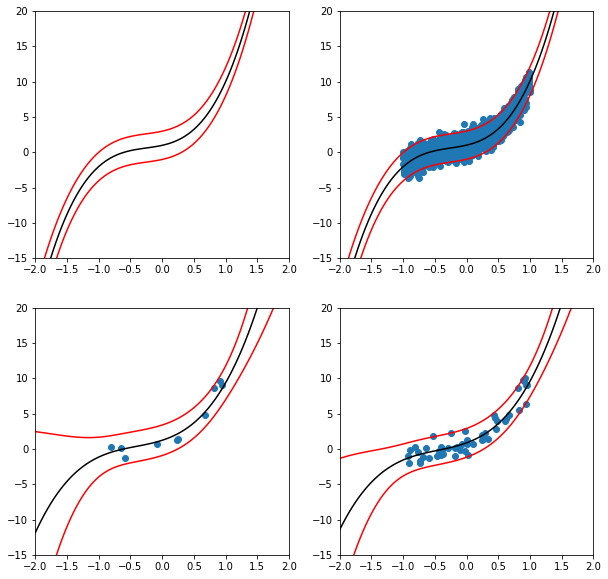

In [125]:
show(1, 1, [1, 2, 3, 4]) #b, a, w